# Finding Vietnamese cuisine food trends using Yelp review data

# 0. Import libraries

In [21]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS 
from tqdm.auto import tqdm
import requests
from bs4 import BeautifulSoup
import re
import unidecode
import matplotlib.pyplot as plt

# 1. Create database of food words

## a) Import a list of generic food words

Download database (sr27asc.csv) from https://catalog.data.gov/dataset/composition-of-foods-raw-processed-prepared-usda-national-nutrient-database-for-standard-r

In [6]:
# Read in the csv of food descriptions, clean and convert to a list of food words
read_des = pd.read_csv('sr27asc/FOOD_DES.txt', sep = "^")
read_des['shortdes'] = read_des['shortdes'].str.replace('~', '', regex = True)
food_list = read_des['shortdes'].values

food_list2 = []
for food in food_list:
    items = food.split(',')
    food_list2.append(items[0])
    
food_list2  = set(food_list2)
food_list2

{'BREAKFAST ITEMS',
 'KELLOGG MINI-WHEATS FRSTD BITE SIZE TOUCH OF FRUIT RAISIN',
 'FENNEL',
 'PUMPKIN LEAVES',
 'CHIA SEEDS',
 'MILKFISH',
 'SMELT',
 'VITASOY USA ORGANIC NASOYA',
 'MUSTARD GREENS',
 'USDA COMMODITY',
 'ENTREES',
 'KRUSTEAZ ALMOND POPPYSEED MUFFIN MIX',
 'CRANBERRIES',
 'FRUIT PUNCH-FLAVOR DRK',
 'KASHI MAYAN HARVEST BAKE',
 'MORNINGSTAR FARMS BRKFST PATTIE W/ ORGANIC SOY',
 'WHEAT FLOURS',
 'CARB BEV',
 "CAMPBELL'S BF GRAVY",
 'TOMATO SAU',
 "CAMPBELL'S SOUP ON THE GO",
 'CHICKPEAS ',
 'GROUND TURKEY',
 'GOOSEBERRIES',
 'PINON NUTS',
 'EGG CUSTARDS',
 'TURNIP GRNS',
 'MEAT DRIPPINGS (LARD',
 'KIWIFRUIT',
 'ENDIVE',
 'ROSE HIPS',
 'MORI-NU',
 'SWEETENERS',
 'PORK&BF SAUSAGE',
 'MORNINGSTAR FARMS CORN DOG',
 'OLIVE GARDEN',
 'OKRA',
 'CHICORY ROOTS',
 'PUMPKIN PIE MIX',
 'HORMEL CANADIAN STYLE BACON',
 'CORN FLR',
 'CHESTNUTS',
 'SILK PLN',
 'TREE FERN',
 'LINGCOD',
 'LUPINS',
 'Tortilla chips',
 'OSCAR MAYER',
 'KANPYO',
 'AMARANTH LEAVES',
 'INF FORMULA',
 'CRANBERRY

## b) Import a list of Vietnamese specific food words from Wikipedia

In [7]:
# Extract text data from the tables in the Vietnamese food entry page
URL = 'https://en.wikipedia.org/wiki/List_of_Vietnamese_dishes'
website_url = requests.get(URL).text
soup = BeautifulSoup(website_url)
tables = soup.find_all('table',{'class':'wikitable sortable'})
viet_food = []

# Most foods in the tables are  hyperlinked, so extract the text that is hyperlinked
for table in tables:
    links = table.findAll('a')
    for link in links:
        food = link.get('title')
        food = re.sub(r"\(.*\)","",str(food))
        food = unidecode.unidecode(food)
        if food != 'None':
            viet_food.append(food)
    
viet_food = [x.strip(' ') for x in viet_food]
viet_food

# There are some common geographic related terms that are hypyerlinked but are not food - exclude these
excludeloc = ['Province', 'Coast', 'Vietnam', 'Hanoi', 'Delta', 'City', 'Saigon']

viet_food_filtered = []
for food in viet_food:
    add = 1
    for loc in excludeloc:
        if loc in food:
            add = 0
            break
    if add == 1:
        viet_food_filtered.append(food.upper())

# The filtered list of Vietnamese cuisine words
viet_food_filtered = set(viet_food_filtered)
viet_food_filtered

{'BALUT',
 'BANH',
 'BANH BA TRANG',
 'BANH BAO',
 'BANH BEO',
 'BANH BO',
 'BANH BOT CHIEN',
 'BANH BOT LOC',
 'BANH BOT LOC LA',
 'BANH BOT LOC TRAN',
 'BANH CAM',
 'BANH CAN',
 'BANH CANH',
 'BANH CAY',
 'BANH CHUNG',
 'BANH CHUOI',
 'BANH CUON',
 'BANH DA',
 'BANH DA LON',
 'BANH DUC',
 'BANH GOI',
 'BANH HOI',
 'BANH IT',
 'BANH IT TRAN',
 'BANH KHOAI MI',
 'BANH KHOT',
 'BANH KHUC',
 'BANH LA',
 'BANH MI',
 'BANH NAM',
 'BANH PHU THE',
 'BANH PHU THE BOT BAN',
 'BANH PIA',
 'BANH RAN',
 'BANH RE',
 'BANH TE',
 'BANH TET',
 'BANH TIEU',
 'BANH TOM',
 'BANH TOM HO TAY',
 'BANH TRANG',
 'BANH TRUNG THU',
 'BANH UOT',
 'BANH XEO',
 'BIA HOI',
 'BINH DINH',
 "BIRD'S EYE CHILI",
 "BIRD'S NEST SOUP",
 'BLACK PUDDING',
 'BO 7 MON',
 'BOLOGNA SAUSAGE',
 'BUN BO HUE',
 'BUN CHA',
 'BUN MANG VIT',
 'BUN OC',
 'BUN RIEU',
 'BUN THIT NUONG',
 'CA MAU',
 'CANH CHUA',
 'CAO LAU',
 'CASSAVA-BASED DISHES',
 'CELLOPHANE NOODLES',
 'CHA',
 'CHA GIO',
 'CHAM CHEO',
 'CHANH MUOI',
 'CHAO TOM',
 'CHAO

## c) Combine the set of food words together

In [8]:
food_list = food_list2 | viet_food_filtered

# 2. Cleaning of the reviews data (partial code)

The reviews data can be downloaded from https://www.yelp.com/dataset/documentation/main. The viet_review.csv file in this code is the reviews.json from the link filtered out for Vietnamese restaurants using the 'categories' information from business.json. The code to create this csv file is not in this notebook.

In [9]:
# Structure of the reviews.json file
reviews = pd.read_csv("../viet_review.csv")
reviews.head()

,review_id,user_id,cool,text,useful,funny,stars,date
0,ydmLJUsQTKrUMmM1hSFjFg,LPva2snYp0Fdu8Z1QIXLiA,0,What can I say? The bread is made daily and t...,1,0,4,2018-02-01 19:18:02
1,eDBC5o8_28FMafDAeT1lJQ,omzXdnZFmB6irpf7jmTQWQ,0,I love the atmosphere ! Perfect for families !...,1,1,5,2016-05-19 05:03:48
2,Nr5hefDW-Yitb3jYgmL2UA,k1zNCz3JODi3YN5sXcKApw,0,My family and I love this place. The food came...,0,0,5,2017-05-13 08:56:04
3,h0WIzX3KjDB4LeIhLQ3bvw,ea-FFbghzx-nm4YZthLJaw,0,Came here on a Saturday for dinner.. there was...,1,0,5,2017-04-30 04:05:21
4,UcBJrncwfqj63u-z1E8Flw,lgh7a1Qey0bbmv5JIQ1beQ,2,So far one of the best customer service I have...,2,1,5,2014-04-01 06:22:54


## Create additional attributes - (1) indicator for a good review (3+ stars) and (2) year of the review

In [10]:
good = [1 if i > 3 else 0 for i in reviews['stars']]
reviews['date'] = pd.to_datetime(reviews['date'])
year = reviews['date'].dt.year
text  = reviews['text']
year_good = pd.DataFrame(year)
year_good['good'] = good
year_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108484 entries, 0 to 108483
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   date    108484 non-null  int64
 1   good    108484 non-null  int64
dtypes: int64(2)
memory usage: 1.7 MB


# 3. Create functions to extract food mentions from reviews

## a) Set up the functions

In [11]:
# A word is a food if it is in the food list created in Step 1
def is_food(word):
    result = word.upper() in food_list
    return result

In [12]:
# A function to extract food phrases based on grammar rules
def food_mention(textlist):
    EXCLUSIONS = ['vietnamese', 'restaurant', 'spot'] # not interested in these food descriptions
    #initiate the columns I want to make
    index_fm = ""
    food_mention = ""

    for review_idx, val in tqdm(enumerate(textlist)):
        blob = TextBlob(val.lower())
        for word_idx, (word, tag) in enumerate(blob.tags[1:(len(blob.tags)-1)], start = 1):
            if is_food(word) and word.lower() not in EXCLUSIONS:
                appended = 0
                if blob.tags[word_idx+1][1].startswith("NN"):#extract food_noun
                    phrase1 = word.lower() + "_" + blob.tags[word_idx+1][0].lower()
                    food_mention += word + " "
                    index_fm += str(review_idx) + " "
                    appended = 1
                if blob.tags[word_idx-1][1].startswith("JJ") or blob.tags[word_idx-1][1].startswith("NN"): #extract noun/adjective_food
                    phrase2 = blob.tags[word_idx-1][0].lower() + "_"  + word.lower() 
                    food_mention += phrase2 + " "
                    index_fm += str(review_idx) + " "
                    appended = 1
                if appended == 0: #extract food by itself
                    food_mention += word.lower() + " "
                    index_fm += str(review_idx) + " "
    frame = {'index_fm': pd.Series(index_fm.split()),'food_mention': pd.Series(food_mention.split())}
    results = pd.DataFrame(frame)
    results['index_fm'] = pd.to_numeric(results['index_fm'])
    return results

In [13]:
#combine food phrases with the year in which the review is mentioned
def combine_list(results):
    food_trend = results.merge(year_good, how = 'left', left_on='index_fm', right_index = True)
    food_trend = food_trend.drop_duplicates()
    return food_trend

In [14]:
#take out 'single' words that are already represented in two word phrases
def process_trend(food_trend):
    #extract single words
    singles = []

    for food in food_trend.food_mention:
        if '_' not in food:
            singles.append(food)

    singles = set(singles)

    singles_to_del = []

    for single in singles:
        for food in food_trend.food_mention:
            if '_' in food:
                if single in food:
                    singles_to_del.append(single)

    singles_to_del = set(singles_to_del)

    food_trend_processed = food_trend[~food_trend['food_mention'].isin(singles_to_del)]

    return food_trend_processed

In [15]:
def extract_food_mention(textlist):
    results = food_mention(textlist)
    combinedlist = combine_list(results)
    food_trend_processed = process_trend(combinedlist)
    return food_trend_processed

## b) Output of the function

In [16]:
food_trend_reviews = extract_food_mention(text)
food_trend_reviews.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 209766 entries, 3 to 548358
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index_fm      209766 non-null  int64 
 1   food_mention  209766 non-null  object
 2   date          209766 non-null  int64 
 3   good          209766 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 8.0+ MB


In [17]:
food_trend_reviews[food_trend_reviews.food_mention == 'lobster_pho']

,index_fm,food_mention,date,good
231,45,lobster_pho,2018,1
425,79,lobster_pho,2017,1
955,185,lobster_pho,2015,1
979,195,lobster_pho,2015,1
1159,227,lobster_pho,2015,1
...,...,...,...,...
534583,105906,lobster_pho,2019,1
535614,106087,lobster_pho,2019,1
535641,106089,lobster_pho,2018,1
537991,106520,lobster_pho,2019,0


In [18]:
reviews.iloc[227,:]

review_id                               uozxNAtDHffqXO0GtR-dCQ
user_id                                 Mho2GibREwsPesKEyQbt8w
cool                                                         7
text         Initially I was going to try Pho Basa last wee...
useful                                                       7
funny                                                        5
stars                                                        5
date                                       2015-04-15 17:51:17
Name: 227, dtype: object

In [43]:
# save as csv output for visualisation on other platform - I used Tableau
food_trend_reviews.to_csv('food_trend_final.csv')

# 4. Create word cloud of food mentions

## Create re-usable functions to create word clouds
I wanted to see if there were any interesting differences of food mentions for all reviews, good review (3+ stars) and bad reviews (<3 stars)

In [19]:
def all_good_bad_values(all_food_mention):
    # split good and bad
    food_trend_filtered_good = all_food_mention[all_food_mention.good == 1.0]
    food_trend_filtered_bad = all_food_mention[all_food_mention.good == 0.0]
    
    food_mention_all = ' '.join(all_food_mention.food_mention.values.tolist())
    food_mention_good = ' '.join(food_trend_filtered_good.food_mention.values.tolist())
    food_mention_bad = ' '.join(food_trend_filtered_bad.food_mention.values.tolist())
    
    return food_mention_all, food_mention_good, food_mention_bad

def create_wc(foodmentionstrings):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(foodmentionstrings) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

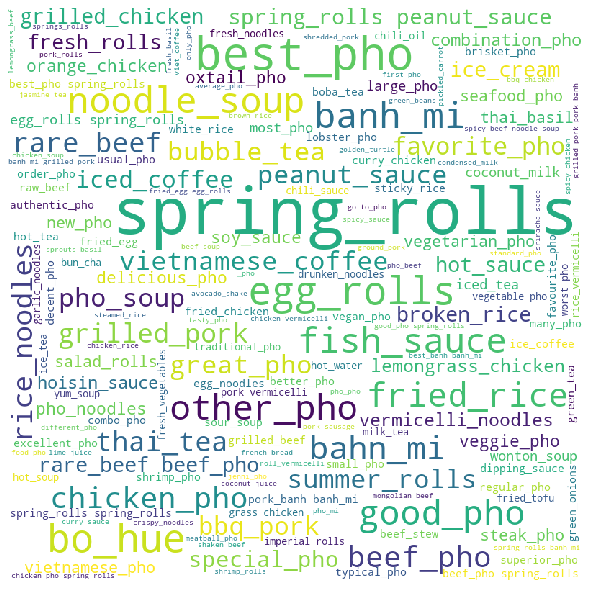

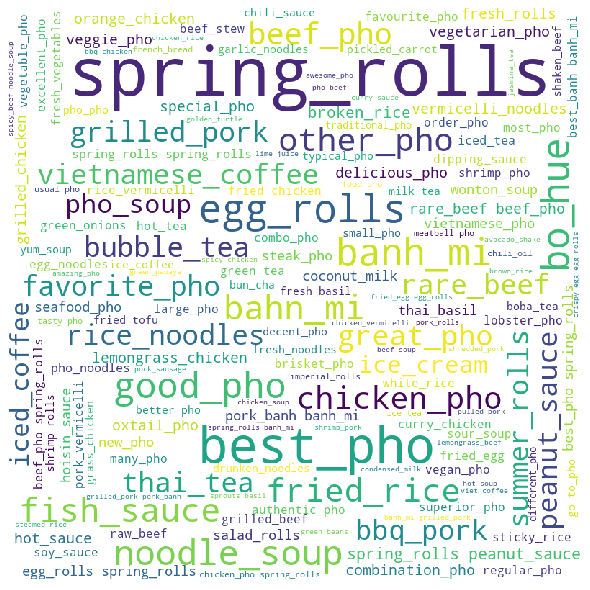

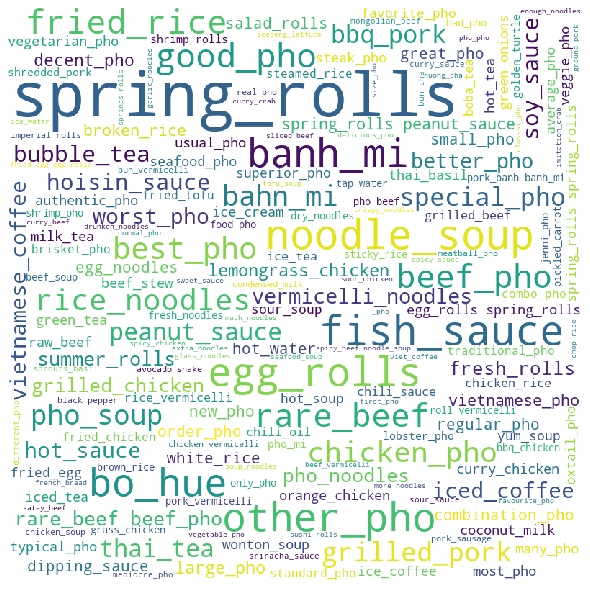

In [22]:
fm_all, fm_good, fm_bad = all_good_bad_values(food_trend_reviews)

for i in ([fm_all, fm_good, fm_bad]):
    create_wc(i)